# Python demo: reading and analyzing genetic data in the PLINK format

This quick Python demo shows how to parse and analyze human genetic data in the PLINK format (bed/fam/bim files). It uses the `pandas-plink` package to parse those files into standard Python data structures (Pandas dataframes and Numpy-array-like objects).

I begin by reading the data and quickly exploring what's inside it and how to access the data. I then run PCA on 1,000 random variants and plot the results as a scatter plot with inidivuals colored by population.

Notably, the IGSR (1000 Genome Project) dataset is originally provided in VCF format, not the PLINK format. The files used in this demo are the result of converting the VCF file into bed/fam/bin files (see the appendix at the end of this notebook for more details).

In [ ]:
# Download IGSR's chromosome 17 in the PLINK format
!mkdir -p ~/IGSR/plink_format/
!wget ftp://ftp.cs.huji.ac.il/users/nadavb/demo/IGSR/plink_format/chr17.bed -P ~/IGSR/plink_format/
!wget ftp://ftp.cs.huji.ac.il/users/nadavb/demo/IGSR/plink_format/chr17.fam -P ~/IGSR/plink_format/
!wget ftp://ftp.cs.huji.ac.il/users/nadavb/demo/IGSR/plink_format/chr17.bim -P ~/IGSR/plink_format/

In [ ]:
!python -m pip install pandas-plink

In [1]:
import os
from IPython.display import display
from pandas_plink import read_plink

# Parse the data and explore the data structures we get back from the pandas-plink package.
variants, samples, genotypes = read_plink(os.path.expanduser('~/IGSR/plink_format/chr17'))
display(variants)
display(samples)
display(genotypes)

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


,chrom,snp,cm,pos,a0,a1,i
0,17,.,0.0,52,A,C,0
1,17,.,0.0,56,T,C,1
2,17,.,0.0,78,C,G,2
3,17,.,0.0,80,A,G,3
4,17,.,0.0,92,T,G,4
...,...,...,...,...,...,...,...
2317394,17,.,0.0,81194184,T,C,2317394
2317395,17,.,0.0,81194256,C,T,2317395
2317396,17,.,0.0,81194394,G,T,2317396
2317397,17,.,0.0,81194398,T,C,2317397


,fid,iid,father,mother,gender,trait,i
0,0,HG00096,0,0,0,-9,0
1,0,HG00097,0,0,0,-9,1
2,0,HG00099,0,0,0,-9,2
3,0,HG00100,0,0,0,-9,3
4,0,HG00101,0,0,0,-9,4
...,...,...,...,...,...,...,...
2499,0,NA21137,0,0,0,-9,2499
2500,0,NA21141,0,0,0,-9,2500
2501,0,NA21142,0,0,0,-9,2501
2502,0,NA21143,0,0,0,-9,2502


dask.array<concatenate, shape=(2317399, 2504), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In this particular fam file (extracted into the `samples` dataframe), most of the columns are empty and don't contain any meaningful information.

In [2]:
# Query the meta data of an arbitrary variant.
display(variants.iloc[426579])

chrom          17
snp             .
cm            0.0
pos      13159006
a0              A
a1              G
i          426579
Name: 426579, dtype: object

In [3]:
# Query the genotypes for this variant.
variant_genotypes = genotypes[426579, :].compute()
print(type(variant_genotypes), len(variant_genotypes), variant_genotypes)

<class 'numpy.ndarray'> 2504 [0. 1. 0. ... 1. 1. 0.]


In [4]:
import pandas as pd
display(pd.Series(variant_genotypes).value_counts().sort_index())

0.0     755
1.0    1070
2.0     679
dtype: int64

## Run PCR on a subset of the variants

In [5]:
import numpy as np
np.random.seed(0)
chosen_variant_indices = np.random.choice(np.arange(len(variants)), 1000)
chosen_variant_indices.sort()
chosen_genotypes = genotypes[chosen_variant_indices, :].compute().transpose()
print('Extracted the genotypes of all %d individuals across %d variants.' % chosen_genotypes.shape)

Extracted the genotypes of all 2504 individuals across 1000 variants.


Text(0, 0.5, 'PC2')

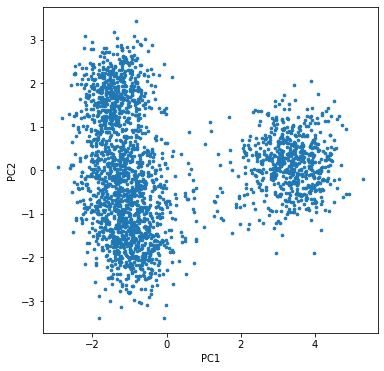

In [6]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
pcs = PCA(n_components = 2).fit_transform(chosen_genotypes)
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(pcs[:, 0], pcs[:, 1], s = 7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

In [ ]:
!mkdir ~/IGSR/populations/
!wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel -P ~/IGSR/populations/

In [7]:
samples_meta = pd.read_csv(os.path.expanduser('~/IGSR/populations/integrated_call_samples_v3.20130502.ALL.panel'), sep = '\t')
display(samples_meta)

,sample,pop,super_pop,gender,Unnamed: 4,Unnamed: 5
0,HG00096,GBR,EUR,male,NaN,NaN
1,HG00097,GBR,EUR,female,NaN,NaN
2,HG00099,GBR,EUR,female,NaN,NaN
3,HG00100,GBR,EUR,female,NaN,NaN
4,HG00101,GBR,EUR,male,NaN,NaN
...,...,...,...,...,...,...
2499,NA21137,GIH,SAS,female,NaN,NaN
2500,NA21141,GIH,SAS,female,NaN,NaN
2501,NA21142,GIH,SAS,female,NaN,NaN
2502,NA21143,GIH,SAS,female,NaN,NaN


Text(0, 0.5, 'PC2')

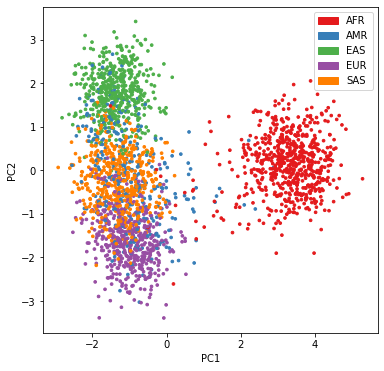

In [8]:
from matplotlib.patches import Patch
unique_pops = np.unique(samples_meta['super_pop'])
pop_to_color = {pop: plt.cm.Set1(i) for i, pop in enumerate(unique_pops)}
sample_pops = samples['iid'].map(samples_meta.set_index('sample')['super_pop'])
sample_pop_colors = sample_pops.map(pop_to_color)
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(pcs[:, 0], pcs[:, 1], c = sample_pop_colors, s = 7)
ax.legend(handles = [Patch(color = pop_to_color[pop], label = pop) for pop in unique_pops])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Appendix - coverting the original VCF file into PLINK files

To convert the original VCF file into PLINK (bed/fam/bim) files, I use the `plink2` tool (which could be downloaded [here](https://www.cog-genomics.org/plink/2.0/)).

Note that this conversion pipeline is simplistic and falls short of a proper pipeline that would typically be used in real research. Specifically:

* It's usually a good idea to run some **quality control** on the VCF data before converting it into PLINK files (for example, filtering out variants and variant calls below a minimum number of reads or other quality scores reported in the VCF).
* I took the quick and dirty approach of ignoring multiallelic variants (`--max-alleles 2`). A more reasonable approach would be to either split them into biallelic variants, or to use a data format that can deal with multiallelic variants.

In [ ]:
# Download the VCF and population (ethnicity) files from IGSR
!mkdir -p ~/IGSR/raw_vcf
!wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz -P ~/IGSR/raw_vcf
!wget http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz.tbi -P ~/IGSR/raw_vcf

In [ ]:
# Convert the VCF to PLINK files
!mkdir ~/IGSR/plink_format
!cd ~/IGSR/plink_format; plink2 --make-bed --max-alleles 2 --out chr17 --vcf ~/IGSR/raw_vcf/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz 